In [1]:
import numpy
import re
from tqdm import tqdm

In [2]:
def text_preprocess(text : str) :
    text = re.sub(r"[^0-9a-zA-Z]",repl=" ",string=text.lower().replace("n't"," not"))
    text = re.sub(r"[0-9]+",repl="N",string=text)
    text = re.sub(r"\s+",repl=" ",string=text)
    return text

def make_dict(sentences : list, word_dict : dict = None) :
    data = " ".join(sentences)
    data = text_preprocess(data).split()
    if word_dict is None :
        word_dict = {}
        word_dict["<pad>"] = 0 #패딩
        word_dict["<unk>"] = 1 #없는 단어
    for w in data :
        if w not in word_dict :
            word_dict[w] = len(word_dict)
    number_dict = {i : w for w, i in word_dict.items()}
    return word_dict, number_dict

def word_num_encoding(sentences : list, word_dict : dict, unk : str = "<unk>") :
    word_size = len(word_dict)
    corpus = []
    max_len = 0
    for s in sentences :
        s = text_preprocess(s).split()
        max_len = max(max_len, len(s))
    for s in sentences :
        s_array = []
        s = text_preprocess(s).split()
        for i in range(max_len) :
            if len(s) <= i :
                s_array.append(0)
                continue
            try :
                s_array.append(word_dict[s[i]])
            except :
                s_array.append(word_dict[unk])
        corpus.append(s_array)
    corpus = numpy.array(corpus)    
    return corpus

def make_comatrix(corpus, word_size, window_size = 1) :
    comatrix = numpy.zeros(shape = (word_size, word_size))
    for s in corpus :
        for w in range(len(s)) :
            if s[w] == 0 :
                continue
            for i in range(1,window_size+1) :
                if w-i >= 0 :
                    if s[w-i] == 0  :
                        continue
                    comatrix[s[w], s[w-i]] += 1
                if w+i < len(s) :
                    if s[w+i] == 0  :
                        continue
                    comatrix[s[w], s[w+i]] += 1
    return comatrix

def cos_similarity(x, y) :
    eps = 1e-15
    return numpy.dot(x,y) / (numpy.linalg.norm(x)*numpy.linalg.norm(y) + eps)

def euc_distance(x, y) :
    return numpy.sqrt(numpy.sum((x - y) ** 2))

def most_similiar(query, word_dict, number_dict, vector_array, top = 5, mode : str = "euc") :
    if query not in word_dict :
        print("{}(이)가 사전에 존재하지 않습니다.".format(query))
        return

    word_size = len(word_dict)
    similiar = numpy.zeros(shape = (word_size))
    if mode.lower() == "euc" :
        for i in range(word_size) :
            similiar[i] = euc_distance(vector_array[word_dict[query]], vector_array[i])
    elif mode.lower() == "cos" :
        for i in range(word_size) :
            similiar[i] = cos_similarity(vector_array[word_dict[query]], vector_array[i])
    else :
        print("{}는 잘못된 모드입니다. 모드 종류 : 'euc', 'cos'".format(mode))
        return
    
    print("검색어 ||",query)
    cnt = 0
    if mode.lower() == "euc" :
        argsort = similiar.argsort()
    elif mode.lower() == "cos" :
        argsort = (-1 * similiar).argsort()
    for i in argsort :
        if number_dict[i] == query :
            continue
        print("{} : {}".format(number_dict[i], similiar[i]))
        cnt += 1
        if cnt >= top :
            break
    print("")

def make_pmi(comatrix, verdose = False) :
    P = numpy.zeros_like(comatrix)
    N = numpy.sum(comatrix)
    S = numpy.sum(comatrix, axis = 0)
    eps = 1e-15
    
    if verdose :
        li = tqdm(range(P.shape[0]))
    else :
        li = range(P.shape[0])
        
    for i in li :
        for j in range(P.shape[1]) :
            pmi = numpy.log2(comatrix[i, j] * N / (S[i]*S[j] + eps) + eps)
            P[i,j] = max(0, pmi)
    return P   

In [3]:
sentence = ["100 say goodbye and I say hello.", "I and You."]
sentences = [
    'He is a king.',
    'She is a queen.',
    'He is a man.',
    'She is a woman.',
    'Warsaw is Poland capital.',
    'Berlin is Germany capital.',
    'Paris is France capital.',
    'Seoul is Korea capital.', 
    'Bejing is China capital.',
    'Tokyo is Japan capital.',
]

word_dict, number_dict = make_dict(sentences)
corpus = word_num_encoding(sentences, word_dict)

print(word_dict)
print(number_dict)
print(corpus)


{'<pad>': 0, '<unk>': 1, 'he': 2, 'is': 3, 'a': 4, 'king': 5, 'she': 6, 'queen': 7, 'man': 8, 'woman': 9, 'warsaw': 10, 'poland': 11, 'capital': 12, 'berlin': 13, 'germany': 14, 'paris': 15, 'france': 16, 'seoul': 17, 'korea': 18, 'bejing': 19, 'china': 20, 'tokyo': 21, 'japan': 22}
{0: '<pad>', 1: '<unk>', 2: 'he', 3: 'is', 4: 'a', 5: 'king', 6: 'she', 7: 'queen', 8: 'man', 9: 'woman', 10: 'warsaw', 11: 'poland', 12: 'capital', 13: 'berlin', 14: 'germany', 15: 'paris', 16: 'france', 17: 'seoul', 18: 'korea', 19: 'bejing', 20: 'china', 21: 'tokyo', 22: 'japan'}
[[ 2  3  4  5]
 [ 6  3  4  7]
 [ 2  3  4  8]
 [ 6  3  4  9]
 [10  3 11 12]
 [13  3 14 12]
 [15  3 16 12]
 [17  3 18 12]
 [19  3 20 12]
 [21  3 22 12]]


In [4]:
comatrix = make_comatrix(corpus, len(word_dict), 2)
print(comatrix)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 4. 1. 2. 1. 1. 1. 1. 1. 6. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 2. 4. 0. 1. 2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.

In [5]:
#좌표간 유사도 비교법 : 코사인 유사도
similarity = cos_similarity(comatrix[word_dict["he"]],comatrix[word_dict["she"]])
print(similarity)

0.9999999999999996


In [6]:
#좌표간 유사도 비교법 : 유클리디언 거리
similarity = euc_distance(comatrix[word_dict["he"]],comatrix[word_dict["she"]])
print(similarity)

0.0


In [7]:
most_similiar("king",word_dict, number_dict, comatrix,5, "euc")

검색어 || king
queen : 0.0
man : 0.0
woman : 0.0
<pad> : 1.4142135623730951
<unk> : 1.4142135623730951



In [8]:
most_similiar("king",word_dict, number_dict, comatrix,5, "cos")

검색어 || king
he : 0.9999999999999996
she : 0.9999999999999996
man : 0.9999999999999993
queen : 0.9999999999999993
woman : 0.9999999999999993



In [9]:
pmi = make_pmi(comatrix) 
print(pmi)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.73696559 2.05889369 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.73696559 0.         0.15200309 0.73696559
  0.73696559 0.73696559 0.73696559 0.73696559 0.73696559 0.15200309
  0.73696559 0.73696559 0.15200309 0.73696559 0.15200309 0.73696559
  0.15200309 0.73696559 0.15200309 0.73696559 0.15200309]
 [0.         0.         

In [10]:
U, S, V = numpy.linalg.svd(pmi)
print(U[2,:2])

[-0.14045692  0.13585612]


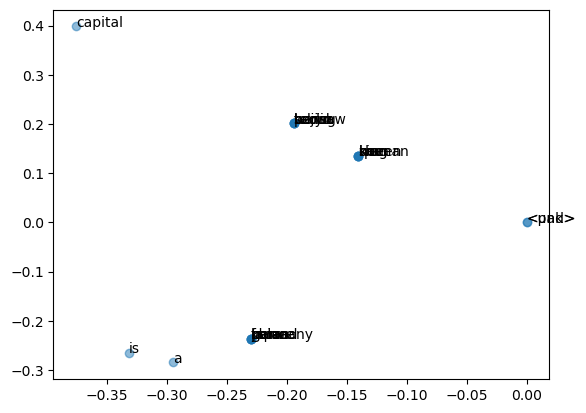

In [11]:
import matplotlib.pyplot as plt

flg, ax = plt.subplots()
for w, i in word_dict.items() :
    #ax.annotate(w, (U[i,0], U[i,1], U[i,2]))
    ax.text(U[i,0], U[i,1], "%s" %(w))
ax.scatter(U[:,0], U[:,1], alpha = 0.5)
plt.show()